In [ ]:
#3. DATA LOADING

import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Set up two generators: one for the majority class and one with extra augmentation for the minority class

# Function to load the datasets
def load_data(train_dir, val_dir):
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescale for validation
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Load train and validation data from the combined dataset
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    return train_generator, validation_generator

# Define the paths to the combined dataset
train_dir = '/content/extracted_folder/dataset_combined/train'
val_dir = '/content/extracted_folder/dataset_combined/validation'

# Load the data
train_generator, validation_generator = load_data(train_dir, val_dir)


Found 865 images belonging to 2 classes.
Found 281 images belonging to 2 classes.


In [ ]:
!unzip /content/dataset_combined.zip -d extracted_folder


Archive:  /content/dataset_combined.zip
   creating: extracted_folder/dataset_combined/
   creating: extracted_folder/dataset_combined/train/
   creating: extracted_folder/dataset_combined/train/no_pores/
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029306.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029307.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029308.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029309.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029310.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029311.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029312.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029313.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029314.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC

In [ ]:
# import os
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf
# import numpy as np

# # Set up data augmentation generator
# augmented_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.3,
#     height_shift_range=0.3,
#     shear_range=0.3,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Directory paths
# input_dir = r'dataset_combined/train/p1'  # Folder with original 'smooth' images
# output_dir = r'dataset_combined/train/pores'  # Folder to save augmented images

# # Ensure output directory exists
# os.makedirs(output_dir, exist_ok=True)

# # Set number of augmentations per image
# num_augmented_images = 10

# # Loop over each image in the "smooth" folder
# for filename in os.listdir(input_dir):
#     if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
#         img_path = os.path.join(input_dir, filename)

#         # Load the image and prepare it for augmentation
#         img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
#         x = tf.keras.preprocessing.image.img_to_array(img)
#         x = np.expand_dims(x, axis=0)

#         # Generate and save augmented images
#         i = 0
#         for batch in augmented_datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix='pores', save_format='jpeg'):
#             i += 1
#             if i >= num_augmented_images:
#                 break  # Stop after saving the desired number of augmentations for each image

# print("Data augmentation completed and saved.")


Data augmentation completed and saved.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming input_shape is (224, 224, 3) for RGB images
def create_model(input_shape=(224, 224, 3)):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (7, 7), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(128, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Added for binary classification
    return model


In [ ]:
#5. MODEL TRAINING AND SAVING
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
# Function to train the model
def train_model(train_generator, validation_generator):
    model = create_model()

    # Compile the model with a reduced learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Calculate class weights for handling class imbalance
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights = dict(enumerate(class_weights))

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with class weights and early stopping
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        class_weight=class_weights,
        callbacks=[early_stopping]
    )

    # Save the trained model
    model.save('pores_model.h5')

    return model

In [ ]:
#6. MODEL EVALUATION

# Function to evaluate the model
def evaluate_model(model, validation_generator_pores):
    test_loss, test_acc = model.evaluate(validation_generator_pores, verbose=2)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")


In [ ]:
import cv2
def load_image_from_path(img_path):
    try:
        # Load the image from the given path
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image at path: {img_path}")
            return None

        # Resize and normalize the image
        img_resized = cv2.resize(img, (224, 224)) / 255.0  # Normalize to [0, 1] range
        img_array = np.expand_dims(img_resized, axis=0)  # Add batch dimension
        return img_array

    except Exception as e:
        print(f"Error loading image: {e}")
        return None
# Function to make a prediction
def make_prediction(model, img_array):
    prediction = model.predict(img_array)
    return prediction

# Function to display the prediction result
def display_prediction_result(prediction, img_path):
    # Prediction is a probability. If it’s closer to 1, it’s likely to be "pore", otherwise "no pore".
    if prediction[0][0] > 0.5:
        print(f"The image {img_path} is classified as having pores (probability: {prediction[0][0]:.2f})")
    else:
        print(f"The image {img_path} is classified as not having pores (probability: {prediction[0][0]:.2f})")


In [ ]:
#9. MAIN

def main():
    # Combined dataset directories
    train_dir = '/content/extracted_folder/dataset_combined/train'
    val_dir = '/content/extracted_folder/dataset_combined/validation'


    # Load data (no need for separate directories now)
    train_generator, validation_generator = load_data(train_dir, val_dir)

    # Train the model
    model = train_model(train_generator, validation_generator)

    # Evaluate the model
    evaluate_model(model, validation_generator)


main()



Found 865 images belonging to 2 classes.
Found 281 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 775ms/step - accuracy: 0.6424 - loss: 0.8443 - val_accuracy: 0.9680 - val_loss: 0.0855
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 495ms/step - accuracy: 0.9128 - loss: 0.2129 - val_accuracy: 0.9786 - val_loss: 0.0466
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 461ms/step - accuracy: 0.9390 - loss: 0.1450 - val_accuracy: 0.9822 - val_loss: 0.0772
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - accuracy: 0.9549 - loss: 0.1127 - val_accuracy: 0.9858 - val_loss: 0.0327
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - accuracy: 0.9328 - loss: 0.1480 - val_accuracy: 0.9822 - val_loss: 0.0652
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 446ms/step - accuracy: 0.9704 - loss: 0.1202 - val_accuracy: 0.9858 - val_loss: 0.0448
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 444ms/step - accuracy: 0.9491 - loss: 0.1225 - val_accuracy: 0.9715 - val_loss: 0.0850


9/9 - 2s - 190ms/step - accuracy: 0.9858 - loss: 0.0327
Test Accuracy: 98.58%


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained model
model = load_model('pore_detection_model.h5')

# Recompile the model with the loss and metrics for evaluation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Now you can evaluate or train the model, and metrics will be available


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step


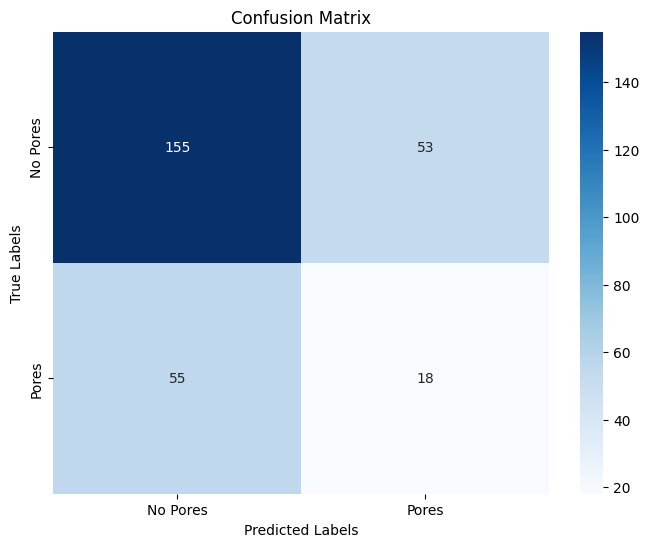

              precision    recall  f1-score   support

    No Pores       0.74      0.75      0.74       208
       Pores       0.25      0.25      0.25        73

    accuracy                           0.62       281
   macro avg       0.50      0.50      0.50       281
weighted avg       0.61      0.62      0.61       281



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('pores_model.h5')

# Generate predictions and true labels for the validation set
true_labels = validation_generator.classes  # True labels from the generator
predictions = model.predict(validation_generator)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary labels

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Pores', 'Pores'], yticklabels=['No Pores', 'Pores'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report for precision, recall, and F1-score
print(classification_report(true_labels, predicted_labels, target_names=['No Pores', 'Pores']))


In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product
import numpy as np

# Define the function to create the model with varying hyperparameters
def create_model(conv1_filters, conv1_kernel, dense_units, dropout_rate, learning_rate):
    model = models.Sequential()
    model.add(layers.Conv2D(conv1_filters, (conv1_kernel, conv1_kernel), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(conv1_filters * 2, (conv1_kernel, conv1_kernel), activation='relu'))  # Increase filters in the second layer
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'conv1_filters': [32, 64],
    'conv1_kernel': [3, 5],
    'dense_units': [128, 256],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [1e-3, 1e-4]
}

# Generate all combinations of parameters
param_combinations = list(product(
    param_grid['conv1_filters'],
    param_grid['conv1_kernel'],
    param_grid['dense_units'],
    param_grid['dropout_rate'],
    param_grid['learning_rate']
))

# Initialize tracking for the best model
best_accuracy = 0
best_params = None
best_model = None

# Loop over all parameter combinations
for i, params in enumerate(param_combinations):
    print(f"\n--- Grid Search Trial {i + 1}/{len(param_combinations)} ---")

    # Unpack parameters
    conv1_filters, conv1_kernel, dense_units, dropout_rate, learning_rate = params

    # Create the model with the current hyperparameters
    model = create_model(conv1_filters, conv1_kernel, dense_units, dropout_rate, learning_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=1 to see training progress
    )

    # Get validation accuracy
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation Accuracy: {val_accuracy:.4f} with params: {params}")

    # Check if this model is the best so far
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = {
            'conv1_filters': conv1_filters,
            'conv1_kernel': conv1_kernel,
            'dense_units': dense_units,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate
        }
        best_model = model

# Print the best hyperparameters and accuracy
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Save the best model
best_model.save('best_model_grid_search.h5')



--- Grid Search Trial 1/32 ---
Validation Accuracy: 0.9929 with params: (32, 3, 128, 0.2, 0.001)

--- Grid Search Trial 2/32 ---
Validation Accuracy: 0.9893 with params: (32, 3, 128, 0.2, 0.0001)

--- Grid Search Trial 3/32 ---
Validation Accuracy: 0.9929 with params: (32, 3, 128, 0.3, 0.001)

--- Grid Search Trial 4/32 ---
Validation Accuracy: 0.9964 with params: (32, 3, 128, 0.3, 0.0001)

--- Grid Search Trial 5/32 ---


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-21-eba014041483>", line 58, in <cell line: 47>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 847135360 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_31125]

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]  # Get the best hyperparameters
model = tuner.hypermodel.build(best_hp)        # Rebuild the model with best hyperparameters
model.summary()                                # Check the model structure


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 220, 220, 96)   │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 110, 110, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 192)  │       460,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 53, 53, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 539328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │   207,102,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,571,009 (791.82 MB)

 Trainable params: 207,571,009 (791.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=Adam(learning_rate=best_hp.get('learning_rate')),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, epochs=10)


Epoch 1/10
10/28 ━━━━━━━━━━━━━━━━━━━━ 1:49 6s/step - accuracy: 0.5235 - loss: 0.8899

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np

# Function to load and preprocess an image based on a file path
def load_image_from_path(img_path):
    try:
        # Load the image from the given path
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image at path: {img_path}")
            return None

        # Resize the image to match the model input size
        img_resized = cv2.resize(img, (224, 224))

        # Rescale pixel values to [0, 1]
        img_normalized = img_resized / 255.0

        # Optional: Apply any additional augmentation as needed for testing consistency with training
        # e.g., horizontal flip or slight rotations if needed

        # Add batch dimension
        img_array = np.expand_dims(img_normalized, axis=0)
        return img_array

    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Function to make a prediction
def make_prediction(model, img_array):
    prediction = model.predict(img_array)
    return prediction

# Function to display the prediction result
def display_prediction_result(prediction, img_path):
    # Prediction is a probability. If it’s closer to 1, it’s likely to be "pore", otherwise "no pore".
    if prediction[0][0] > 0.5:
        print(f"The image {img_path} is classified as having pores (probability: {prediction[0][0]:.2f})")
    else:
        print(f"The image {img_path} is classified as not having pores (probability: {prediction[0][0]:.2f})")

# Main loop to test the model on a selected image
if __name__ == "__main__":
    # Prompt the user to enter an image path
    img_path = input("Please enter the path to the image: ").strip()

    # Load and preprocess the image
    img_array = load_image_from_path(img_path)

    if img_array is not None:
        prediction = make_prediction(model, img_array)
        display_prediction_result(prediction, img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The image dataset_combined\validation\pores\Screenshot 2024-10-14 222256.png is classified as not having pores (probability: 0.15)


In [ ]:
import cv2
image = cv2.imread(r"dataset_combined/validation/pores/Screenshot 2024-10-14 220842.png")
gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)

blurred =  cv2.GaussianBlur(gray ,(5,5),0)
_, thresh = cv2.threshold(blurred , 0, 255 , cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
edges = cv2.Canny(thresh , 50,150)
contours, _ = cv2.findContours(thresh , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)

for countor in contours :
    area = cv2.contourArea(countor)
    x,y,h,w =cv2.boundingRect(countor)


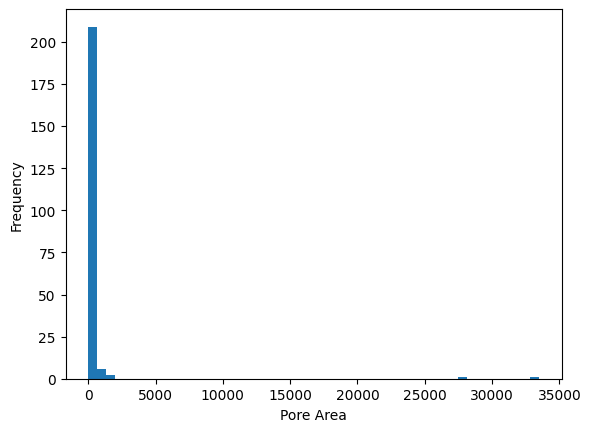

In [ ]:
import matplotlib.pyplot as plt

areas = [cv2.contourArea(c) for c in contours]
plt.hist(areas, bins=50)
plt.xlabel('Pore Area')
plt.ylabel('Frequency')
plt.show()
